# <center> Реализация алгоритма построения дерева решений

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.base import BaseEstimator
from sklearn.datasets import make_classification, make_regression, load_digits, load_boston
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error

Зафиксируем заранее `random_state` (a.k.a. random seed). Это должно повысить вероятность полной воспроизводимости результатов, впрочем, замечено, что тем не менее небольшие флуктуации возможны (например, качества прогнозов дерева, которое мы сейчас вырастим) в случае разных ОС.

In [2]:
RANDOM_STATE = 17

**Необходимо реализовать класс `DecisionTree`**

**Спецификация:**
- класс наследуется от `sklearn.BaseEstimator`;
- конструктор содержит следующие параметры: 
    `max_depth` - максимальная глубина дерева (по умолчанию - `numpy.inf`); 
    `min_samples_split` - минимальное число объектов в вершине, при котором происходит её разбиение (по умолчанию - 2); 
    `criterion` - критерий разбиения (для классификации - 'gini' или 'entropy', для регрессии - 'variance' или 'mad_median'; 
    по умолчанию - 'gini');
    
    Функционал, значение которого максимизируется для поиска оптимального разбиения в данной вершине имеет вид
    $$Q(X, j, t) = F(X) - \dfrac{|X_l|}{|X|} F(X_l) - \dfrac{|X_r|}{|X|} F(X_r),$$
    где $X$ - выборка, находящаяся в текущей вершине, $X_l$ и $X_r$ - разбиение выборки $X$ на две части 
    по предикату $[x_j < t]$, а $F(X)$ -критерий разбиения.
    
    Для классификации: пусть $p_i$ - доля объектов $i$-го класса в выборке $X$.
    
    'gini': Неопределенность Джини $F(X) = 1 -\sum_{i = 1}^K p_i^2$.
    
    'entropy': Энтропия $F(X) = -\sum_{i = 1}^K p_i \log_2(p_i)$.
    
    Для регрессии: $y_j = y(x_j)$ - ответ на объекте $x_j$, $y = (y_1, \dots, y_{|X|})$ - вектор ответов.
    
    'variance': Дисперсия (среднее квадратичное отклонение от среднего) $F(X) = \dfrac{1}{|X|} \sum_{x_j \in X}(y_j - \dfrac{1}{|X|}\sum_{x_i \in X}y_i)^2$
    
    'mad_median': Среднее отклонение от медианы $F(X) = \dfrac{1}{|X|} \sum_{x_j \in X}|y_j - \mathrm{med}(y)|$
    
- класс имеет методы `fit`, `predict` и `predict_proba`;
- метод `fit` принимает матрицу объектов `X` и вектор ответов `y` (объекты `numpy.ndarray`) и возвращает экземпляр класса
    `DecisionTree`, представляющий собой решающее дерево, обученное по выборке `(X, y)` с учётом заданных в конструкторе параметров; 
- метод `predict_proba` принимает матрицу объектов `X` и возвращает матрицу `P` размера `X.shape[0] x K`, где `K` - число классов, такую что $p_{ij}$ есть вероятность принадлежности объекта, заданного $i$-ой строкой матрицы X к классу $j \in \{1, \dots, K\}$.
- метод `predict` принимает матрицу объектов и возвращает вектор предсказанных ответов; в случае классификации - это 
    наиболее многочисленный класс в листе, в который попал объект, а в случае регрессии - среднее значение ответов по 
    всем объектам этого листа;

In [3]:
import os
import sys

current_dir = os.getcwd()
if current_dir not in sys.path:
    sys.path.append(current_dir)

from decision_tree import *

## Тестирование реализованного алгоритма

### Классификация

С помощью метода `load_digits` загрузите датасет `digits`. Разделите выборку на обучающую и тестовую с помощью метода `train_test_split`, используйте значения параметров `test_size=0.2`, `random_state=17`. Попробуйте обучить неглубокие решающие деревья и убедитесь, что критерии gini и entropy дают разные результаты.

In [4]:
digits_dataset = load_digits()

In [5]:
print("Ключи digits_dataset: \n{}".format(digits_dataset.keys()))

Ключи digits_dataset: 
dict_keys(['data', 'target', 'target_names', 'images', 'DESCR'])


Разделите выборку на обучающую и тестовую с помощью метода train_test_split, используйте значения параметров test_size=0.2, random_state=17. Попробуйте обучить неглубокие решающие деревья и убедитесь, что критерии gini и entropy дают разные результаты.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
digits_dataset['data'], digits_dataset['target'], test_size=0.2, random_state=RANDOM_STATE)

#### Критерий gini на обучающей выбоке

In [7]:
%%time

tree = DecisionTree(criterion='gini', max_depth=3)
tree.fit(X_train, y_train)

train_set_score = accuracy_score(y_train, tree.predict(X_train))
print("Train set accuracy: {:.3f}".format(train_set_score))

Train set accuracy: 0.635
Wall time: 3.07 s


In [8]:
%%time
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(criterion='gini', max_depth=3, random_state=RANDOM_STATE) # TODO
tree.fit(X_train, y_train)
train_set_score = accuracy_score(y_train, tree.predict(X_train))
print("sklearn DecisionTreeClassifier train set accuracy: {:.3f}".format(train_set_score))

sklearn DecisionTreeClassifier train set accuracy: 0.494
Wall time: 250 ms


#### Критерий entropy на обучающей выборке

In [9]:
%%time

tree = DecisionTree(criterion='entropy', max_depth=3)
tree.fit(X_train, y_train)

train_set_score = accuracy_score(y_train, tree.predict(X_train))
print("Train set accuracy: {:.3f}".format(train_set_score))

Train set accuracy: 0.649
Wall time: 3.32 s


In [10]:
tree = DecisionTreeClassifier(criterion='entropy', max_depth=3) # TODO
tree.fit(X_train, y_train)

train_set_score = accuracy_score(y_train, tree.predict(X_train))
print("sklearn DecisionTreeClassifier train set accuracy: {:.3f}".format(train_set_score))

sklearn DecisionTreeClassifier train set accuracy: 0.552


С помощью 5-кратной кросс-валидации (`GridSearchCV`) подберите оптимальное значение параметров `max_depth` и `criterion`. Для параметра `max_depth` используйте диапазон значений - range(3, 11), а для criterion - {'gini', 'entropy'}. Критерий качества `scoring`='accuracy'.

In [11]:
criterions = ['gini', 'entropy']
tree_params = {'max_depth': range(3,14), 'criterion': criterions}
criteration = {'gini', 'entropy'}

tree = DecisionTree()
tree_grid = GridSearchCV(tree, tree_params, cv=5, n_jobs=-1, scoring='accuracy', verbose=True, return_train_score=True)
tree_grid.fit(X_train, y_train)

Fitting 5 folds for each of 22 candidates, totalling 110 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 110 out of 110 | elapsed:  9.6min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTree(criterion='gini', debug=False, max_depth=inf,
       min_samples_split=2),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': range(3, 14), 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=True)

Постройте графики средних значений критерия качества `accuracy` для критериев `gini` и `entropy` в зависимости от `max_depth`.

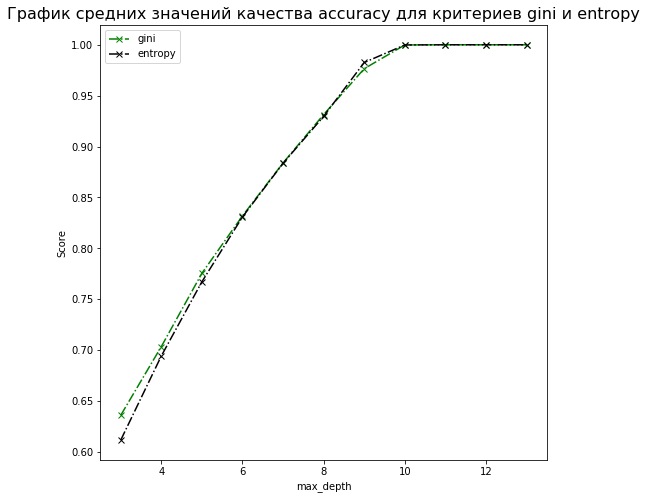

In [12]:
results = tree_grid.cv_results_

plt.figure(figsize=(8, 8))
plt.title("График средних значений качества accuracy для критериев gini и entropy",
          fontsize=16)
plt.xlabel("max_depth")
plt.ylabel("Score")

for criteria, color in zip(criterions, ['g', 'k']):
    mask = [results['param_criterion'].data == criteria]
    x = results['param_max_depth'].data[mask]
    y = results['mean_train_score'][mask]
    plt.plot(x, y, linestyle='-.', marker='x', color=color, label=criteria)
    
plt.legend(loc="best")
plt.show()

**Выберите верные утверждения:**
1. Оптимальное значение `max_depth` для каждого критерия достигается на отрезке [4, 9].
2. На отрезке [3, 10] построенные графики не пересекаются. [x] <--для sklearn.tree.DecisionTreeClassifier
3. **На отрезке [3, 10] построенные графики пересекаются ровно один раз.** <-- custom
4. Наилучшее качество при `max_depth` на интервале [3, 10] достигается при использовании критерия `gini`.
5. **Хотя бы для одного из критериев значение accuracy строго возрастает с ростом значения `max_depth` на интервале [3, 10].[x]**

In [13]:
tree_grid.best_params_

{'criterion': 'entropy', 'max_depth': 7}

**Чему равны найденные оптимальные значения параметров max_depth и criterion?**
1. max_depth = 7, criterion = 'gini';
2. **max_depth = 7, criterion = 'entropy';** <-- Custom
3. max_depth = 10, criterion = 'entropy';
4. max_depth = 10, criterion = 'gini';
5. **max_depth = 9, criterion = 'entropy';** <-- sklearn
6. max_depth = 9, criterion = 'gini';

Используя найденные оптимальные значения max_depth и criterion, обучите решающее дерево на X_train, y_train и вычислите вероятности принадлежности к классам для X_test.

In [14]:
best_estimator = tree_grid.best_estimator_
best_estimator.fit(X_train, y_train)

test_predictions = best_estimator.predict(X_test)
test_set_score = accuracy_score(y_test, test_predictions)
print("Train set accuracy: {:.3f}".format(test_set_score))

Train set accuracy: 0.769


Для полученной матрицы вычислите усредненные по всем объектам из `X_test` значения вероятностей принадлежности к классам.

In [15]:

np.mean([test_predictions == y_test]) / len(range(0, 10))


0.076944444444444454

**Вопрос:** Чему примерно равна максимальная вероятность в полученном векторе?
1. 0.127
2. 0.118
3. 1.0
4. **0.09**

### Регрессия

С помощью метода `load_boston` загрузите датасет `boston`. Разделите выборку на обучающую и тестовую с помощью метода `train_test_split`, используйте значения параметров `test_size=0.2`, `random_state=17`. Попробуйте обучить неглубокие регрессионные деревья и убедитесь, что критерии `variance` и `mad_median` дают разные результаты.

In [16]:
boston_dataset = load_boston()
boston_dataset.keys()

X_train, X_test, y_train, y_test = train_test_split(
    boston_dataset['data'], boston_dataset['target'], test_size=0.2, random_state=17)
X_train.shape, X_test.shape

((404, 13), (102, 13))

In [ ]:
#print(boston_dataset['DESCR'])

#### Критерий variance на обучающей выборке

In [17]:
%%time

tree = DecisionTree(criterion='variance', max_depth=3)
tree.fit(X_train, y_train)

train_set_score = mean_squared_error(y_train, tree.predict(X_train))
print("Train set squared error: {:.3f}".format(train_set_score))

Train set squared error: 17.146
Wall time: 2.53 s


#### Критерий mad_median на обучающей выборке 

In [18]:
%%time

tree = DecisionTree(criterion='mad_median', max_depth=3)
tree.fit(X_train, y_train)

train_set_score = mean_squared_error(y_train, tree.predict(X_train))
print("Train set squared error: {:.3f}".format(train_set_score))

Train set squared error: 17.886
Wall time: 6.3 s


С помощью 5-кратной кросс-валидации подберите оптимальное значение параметров `max_depth` и `criterion`. Для параметра `max_depth` используйте диапазон значений - `range(2, 9)`, а для `criterion` - {'variance', 'mad_median'}. Критерий качества `scoring`='neg_mean_squared_error'.

In [19]:
criterions = ['variance', 'mad_median']
tree_params = {'max_depth': range(2,9), 'criterion': criterions}

tree = DecisionTree()
tree_grid = GridSearchCV(tree, tree_params, cv=5, n_jobs=-1, scoring='neg_mean_squared_error', verbose=True, return_train_score=True)
tree_grid.fit(X_train, y_train)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:  2.3min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTree(criterion='gini', debug=False, max_depth=inf,
       min_samples_split=2),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': range(2, 9), 'criterion': ['variance', 'mad_median']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=True)

Постройте графики средних значений критерия качества `neg_mean_squared_error` для критериев `variance` и `mad_median` в зависимости от `max_depth`.

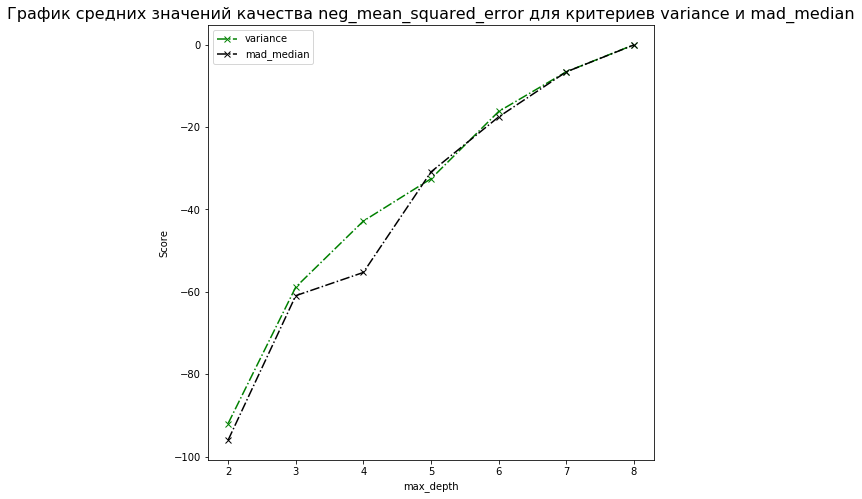

In [20]:
results = tree_grid.cv_results_

plt.figure(figsize=(8, 8))
plt.title("График средних значений качества neg_mean_squared_error для критериев variance и mad_median",
          fontsize=16)
plt.xlabel("max_depth")
plt.ylabel("Score")

for criteria, color in zip(criterions, ['g', 'k']):
    mask = [results['param_criterion'].data == criteria]
    x = results['param_max_depth'].data[mask]
    y = results['mean_train_score'][mask]
    plt.plot(x, y, linestyle='-.', marker='x', color=color, label=criteria)

plt.legend(loc="best")
plt.show()

**Выберите верные утверждения:**
1. На отрезке [2, 8] построенные графики не пересекаются.
2. На отрезке [2, 8] построенные графики пересекаются ровно один раз.
3. **Оптимальное значение `max_depth` для каждого из критериев достигается на границе отрезка [2, 8].**
4. Наилучшее качество при `max_depth` из [2, 8] достигается при использовании критерия `mad_median`.

In [21]:
tree_grid.best_params_

{'criterion': 'variance', 'max_depth': 8}

**Чему равны найденные оптимальные значения параметров `max_depth` и `criterion`?**
1. **max_depth = 9, criterion = 'variance';** <-- самое близкое к tree_grid.best_params_
2. max_depth = 5, criterion = 'mad_median';
3. max_depth = 4, criterion = 'variance';
4. max_depth = 2, criterion = 'mad_median';
5. max_depth = 4, criterion = 'mad_median';
6. max_depth = 5, criterion = 'variance';